Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [ ]:
# install and login for Weights & Biases
!pip install wandb
!wandb login 

# Note!!! Veuillez lire le phrase suivante avant d'exécuter tout code
Exécutez les deux blocs de codes qui suivent seulement si vous allez exécuter ce ficher sur Colab. Ignorez-les sinon.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Transfering dataset from cloud to colab local disk, which is faster
import shutil
shutil.copytree('/content/drive/MyDrive/Animals_with_Attributes2/','AWA2')

'AWA2'

# Environnement dont on aura besoin:

In [ ]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(0)

## Note!!! Veuillez d'abord lire le texte suivant avant d'exécuter les blocs de codes suivants
Si vous venez d'exécuter ces deux blocs de codes-là au début du fichier, vous pouvez exécuter le bloc qui suit sans toute modification.
Sinon, vous devez modifier les deux chemins, le premier vers le dossier "Animals_with_Attributes2" dans votre environnement, le deuxième vers son sous-dossier "JPEGImages".


In [ ]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
DATA_FOLDER_PATH = '/content/AWA2/'
JPEGIMAGES_FOLDER_PATH = '/content/AWA2/JPEGImages/'

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [ ]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH) -> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()

In [ ]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')
create_annotations_csv_file()

In [ ]:
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [ ]:
from torchvision.io import read_image, ImageReadMode
from PIL import Image

class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]
        image = read_image(path = img_path, mode = ImageReadMode.RGB)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

class Subset_(AWA2Dataset) : 
    def __init__(self, dataset, indices, transform=None):
        super().__init__()
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        original_index_in_AWA2Dataset = self.indices[index]
        image, label = self.dataset[original_index_in_AWA2Dataset]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

In [ ]:
transforms_pipeline_train = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    transforms.RandomRotation(15),
                    transforms.RandomHorizontalFlip(p=0.4),
                    transforms.ColorJitter(brightness=0.2,
                                            contrast=0.2,
                                            saturation=0.2,
                                            hue=0.1),
                    transforms.RandomCrop((224,224)),  # transforms.RandomResizedCrop(size=(224,224), scale=(0.6, 0.9), ratio=(0.5, 1.08,))
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


transforms_pipeline_test = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    # transforms.Grayscale(num_output_channels=3),
                    transforms.CenterCrop((224,224)),   
                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])
transforms_resize = transforms.Compose([
                    ## Input size
                    transforms.ToPILImage(),
                    transforms.Resize((224,224)),

                    ## Normalize
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the 
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538]) # real mean and std of AwA2
                ])


# Initialize dataset and train/valid/test split 
from sklearn.model_selection import train_test_split

dataset = AWA2Dataset()
n_images = len(dataset)
# Split all indices into training/testing sets
train_indices, test_indices = train_test_split(range(n_images), test_size=0.2, random_state=1)
# Split training indices into training/validation sets.
train_indices, valid_indices = train_test_split(train_indices, test_size=0.2, random_state=1)

"""
You can comment the following 3 lines of codes and uncomment the 3 lines of codes 
following "# W/O data augmentation" to use the dataset without data augmentation.
"""
# Initialize the 3 DataSet objects (as Subset_) and apply the relevant Transforms to each subset (train/test/valid)
train_data = Subset_(dataset, train_indices, transform = transforms_pipeline_train)
valid_data = Subset_(dataset, valid_indices, transform = transforms_pipeline_test)
test_data  = Subset_(dataset, test_indices, transform = transforms_pipeline_test) 

# W/O data augementation
# train_data = Subset_(dataset, train_indices, transform = transforms_resize)
# valid_data = Subset_(dataset, valid_indices, transform = transforms_resize)
# test_data  = Subset_(dataset, test_indices, transform = transforms_resize) 

# Initalize DataLoaders
batch_size = 128
train_dataloader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True,  num_workers=6,pin_memory=True)
valid_dataloader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_dataloader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


# Importation de EfficientNet

In [ ]:
!pip install efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=c72df37a2be32b53186255f1f199fddf364c04f8f7f48426752ea024a9148e8e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import torch.nn as nn
from torchvision import models
from efficientnet_pytorch import EfficientNet

# Train LeNet and EfficientNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=50):
      super(LeNet, self).__init__()
      self.conv = nn.Sequential(
          #input: 3 x 224 x 224
          nn.Conv2d(3, 6, 5),
          #(224+1-5) = 220 -> 6 x 220 x 220
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          #220/2 = 110 -> 6 x 110 x 110
          nn.Conv2d(6, 16, 5),
          #(110+1-5) = 106 -> 6 x 106 x 106
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
          #(106/2 = 53) -> 16 * 53 * 53
      )
      self.fc = nn.Sequential(
          #adjusted from LeNet, fully connected input dimension= output calculated from above 16 * 53 * 53
          nn.Linear(16 * 53 * 53, 120),
          nn.ReLU(),

          #same as classic LeNet
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84, num_classes)
      )

    def forward(self, img):
        feature = self.conv(img)
        x = torch.flatten(feature, 1)
        output = self.fc(x)
        return output


#Lenet model 
lenet = LeNet()

#EfficientNet Model
# not pre-trained
eff = EfficientNet.from_name('efficientnet-b0', num_classes=50)
# pre-trained
# eff = EfficientNet.from_pretrained('efficientnet-b0', num_classes=50)

In [ ]:
# initialize a Weights & Biases charts section
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Eff_wo_pre_w_reg_new",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 50,
    }
)

wandb: Currently logged in as: chiatiyu64 (animal-detect-vit). Use `wandb login --relogin` to force relogin


In [ ]:
# installing progress bar
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm.notebook import tqdm

model = eff
model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

#Train
for epoch in range(50):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

        # wandb.log({"train_loss_1" : loss.item()})

#Validation
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_dataloader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_dataloader)
            epoch_val_loss += val_loss / len(valid_dataloader)

    print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

    # log metrics to wandb
    wandb.log({"train_loss":epoch_loss,"train_acc": epoch_accuracy,"val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

# save model to file in Google Drive
model_path = '/content/drive/MyDrive/EffModel/eff_wo_pre_w_reg_50.pth'
torch.save(model.state_dict(), model_path)

  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.3453 - acc: 0.1221 - val_loss : 2.9726 - val_acc: 0.1928



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.7887 - acc: 0.2371 - val_loss : 2.5173 - val_acc: 0.2975



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.3670 - acc: 0.3436 - val_loss : 2.1919 - val_acc: 0.3865



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.0917 - acc: 0.4114 - val_loss : 1.9215 - val_acc: 0.4585



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.8674 - acc: 0.4701 - val_loss : 1.6965 - val_acc: 0.5248



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.6860 - acc: 0.5139 - val_loss : 1.5507 - val_acc: 0.5563



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.5329 - acc: 0.5590 - val_loss : 1.4648 - val_acc: 0.5779



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.4133 - acc: 0.5868 - val_loss : 1.3836 - val_acc: 0.6044



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.3005 - acc: 0.6174 - val_loss : 1.2792 - val_acc: 0.6303



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.2083 - acc: 0.6425 - val_loss : 1.2043 - val_acc: 0.6560



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.1043 - acc: 0.6749 - val_loss : 1.1195 - val_acc: 0.6649



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.0242 - acc: 0.6935 - val_loss : 1.0785 - val_acc: 0.6845



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.9547 - acc: 0.7135 - val_loss : 1.0596 - val_acc: 0.6932



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.8839 - acc: 0.7311 - val_loss : 1.0124 - val_acc: 0.7041



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.8202 - acc: 0.7471 - val_loss : 0.9855 - val_acc: 0.7122



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.7706 - acc: 0.7625 - val_loss : 0.9385 - val_acc: 0.7272



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.7065 - acc: 0.7819 - val_loss : 0.9221 - val_acc: 0.7298



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6713 - acc: 0.7904 - val_loss : 0.9149 - val_acc: 0.7359



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6199 - acc: 0.8051 - val_loss : 0.9124 - val_acc: 0.7373



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5777 - acc: 0.8180 - val_loss : 0.8985 - val_acc: 0.7450



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.5405 - acc: 0.8271 - val_loss : 0.8944 - val_acc: 0.7455



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.5069 - acc: 0.8366 - val_loss : 0.8640 - val_acc: 0.7570



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.4740 - acc: 0.8472 - val_loss : 0.8928 - val_acc: 0.7520



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.4461 - acc: 0.8547 - val_loss : 0.8662 - val_acc: 0.7610



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.4074 - acc: 0.8662 - val_loss : 0.8840 - val_acc: 0.7597



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.3821 - acc: 0.8768 - val_loss : 0.8681 - val_acc: 0.7650



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.3724 - acc: 0.8783 - val_loss : 0.8743 - val_acc: 0.7639



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.3341 - acc: 0.8890 - val_loss : 0.9201 - val_acc: 0.7666



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.3108 - acc: 0.8963 - val_loss : 0.9308 - val_acc: 0.7587



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.2902 - acc: 0.9025 - val_loss : 0.8812 - val_acc: 0.7707



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.2676 - acc: 0.9125 - val_loss : 0.9094 - val_acc: 0.7726



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.2539 - acc: 0.9148 - val_loss : 0.9647 - val_acc: 0.7672



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.2315 - acc: 0.9218 - val_loss : 0.9558 - val_acc: 0.7656



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.2435 - acc: 0.9187 - val_loss : 0.9340 - val_acc: 0.7763



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.2092 - acc: 0.9298 - val_loss : 0.9690 - val_acc: 0.7657



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.2213 - acc: 0.9261 - val_loss : 0.9733 - val_acc: 0.7643



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.2026 - acc: 0.9327 - val_loss : 0.9968 - val_acc: 0.7609



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.1957 - acc: 0.9359 - val_loss : 0.9827 - val_acc: 0.7701



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.1863 - acc: 0.9367 - val_loss : 0.9879 - val_acc: 0.7675



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.1547 - acc: 0.9476 - val_loss : 0.9646 - val_acc: 0.7768



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.1750 - acc: 0.9405 - val_loss : 1.0239 - val_acc: 0.7699



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.1633 - acc: 0.9485 - val_loss : 1.0221 - val_acc: 0.7705



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.1474 - acc: 0.9522 - val_loss : 0.9938 - val_acc: 0.7725



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.1484 - acc: 0.9513 - val_loss : 1.0014 - val_acc: 0.7746



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.1513 - acc: 0.9507 - val_loss : 1.0326 - val_acc: 0.7694



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.1492 - acc: 0.9499 - val_loss : 1.0388 - val_acc: 0.7768



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.1350 - acc: 0.9541 - val_loss : 1.0076 - val_acc: 0.7773



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.1265 - acc: 0.9589 - val_loss : 1.0420 - val_acc: 0.7773



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.1332 - acc: 0.9555 - val_loss : 1.0816 - val_acc: 0.7711



  0%|          | 0/187 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.1317 - acc: 0.9559 - val_loss : 1.0581 - val_acc: 0.7719



train_acc,▁▂▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▇▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▃▄▅▆▆▆▇▇▇▇▇▇██████████████████████████
val_loss,█▆▅▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▂▂
train_acc,0.95586
train_loss,0.13167
val_acc,0.77185
val_loss,1.05813


# Load models from drive

In [ ]:
Lenet_wo_reg_path = "/content/drive/My Drive/LenetModel/lenet_wo_reg.pth"
Lenet_w_reg_path = "/content/drive/My Drive/LenetModel/Lenet_wo_pre_50.pth"
Eff_wo_pre_wo_reg_path = "/content/drive/My Drive/EffModel/Eff_wo_pre_wo_reg_50.pth"
Eff_wo_pre_path = "/content/drive/My Drive/EffModel/eff_wo_pre_w_reg_50.pth"
Eff_w_pre_reg_path = "/content/drive/My Drive/EffModel/eff_pre_50.pth"

# model = EfficientNet.from_name('efficientnet-b0', num_classes=50)
# model.load_state_dict(torch.load(Eff_wo_pre_wo_reg_path))
# model.to(device)
# model.eval()

model = LeNet()
model.load_state_dict(torch.load(Lenet_w_reg_path))
model.to(device)
model.eval()

LeNet(
  (conv): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=44944, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=50, bias=True)
  )
)

# Test models

In [ ]:
#Test phase

from tqdm.notebook import tqdm
correct = 0
total = 0
y_true = []
y_pred = []
wrong_pred =[]
right_label = []
with torch.no_grad():

    for data,label in tqdm(test_dataloader):

        data = data.to(device)
        label = label.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(label.tolist())
        total += label.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != label[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(label[i].item())
        
        correct += (predicted == label).sum().item()

print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))


from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))


  0%|          | 0/59 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the model on the test images: 50.96%
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       203
           1       0.48      0.45      0.47       167
           2       0.47      0.37      0.42        43
           3       0.23      0.12      0.16        40
           4       0.80      0.78      0.79       120
           5       0.38      0.26      0.31       144
           6       0.44      0.58      0.50       314
           7       0.38      0.28      0.32       222
           8       0.29      0.13      0.18        31
           9       0.46      0.21      0.29        91
          10       0.47      0.21      0.29        43
          11       0.57      0.22      0.32        18
          12       0.52      0.90      0.66       154
          13       0.34      0.30      0.32       143
          14       0.86      0.73      0.79       148
          15       0.37      0.39      0.38       152
          16       0.50      0.1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


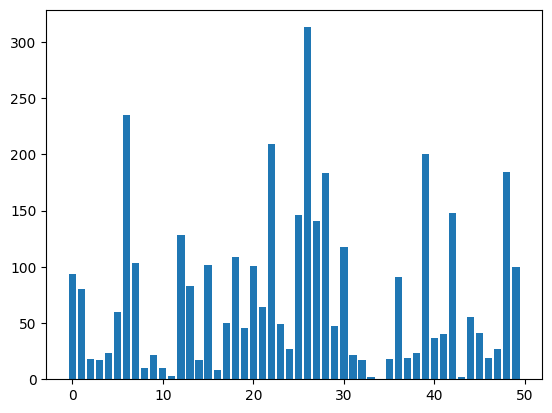

In [ ]:
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt

path_class = DATA_FOLDER_PATH +"classes.txt"
class_animal = pd.read_table(path_class,header= None)
# class_animal
animals = class_animal[1]
dict_label_animal = {}
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels) 

nb_wrong_pred = []
for i in range(0,50):
    nb_wrong_pred.append(wrong_pred.count(i))

list_animal = list(dict_label_animal.keys())

plt.bar(range(50), nb_wrong_pred)
plt.show()

In [ ]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_wrong_pred[i]<=75:
        good_classification.append(i)
        # print("g")
    if nb_wrong_pred[i]>=100:
        # print("bad")
        bad_classification.append(i)

def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(wrong_pred) if x == m]:
        wrong_pred_m.append(right_label[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

for i in good_classification :
    print('Model a bien classifie '+animals[i])

Model a bien classifie killer+whale
Model a bien classifie beaver
Model a bien classifie dalmatian
Model a bien classifie persian+cat
Model a bien classifie blue+whale
Model a bien classifie siamese+cat
Model a bien classifie skunk
Model a bien classifie mole
Model a bien classifie leopard
Model a bien classifie spider+monkey
Model a bien classifie humpback+whale
Model a bien classifie gorilla
Model a bien classifie fox
Model a bien classifie seal
Model a bien classifie chimpanzee
Model a bien classifie bat
Model a bien classifie wolf
Model a bien classifie chihuahua
Model a bien classifie rat
Model a bien classifie weasel
Model a bien classifie otter
Model a bien classifie zebra
Model a bien classifie giant+panda
Model a bien classifie bobcat
Model a bien classifie pig
Model a bien classifie mouse
Model a bien classifie polar+bear
Model a bien classifie collie
Model a bien classifie walrus
Model a bien classifie raccoon


In [ ]:
for i in bad_classification:
  print('Model a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

Model a mal classifie horse , melange souvent avec cow
Model a mal classifie german+shepherd , melange souvent avec collie
Model a mal classifie tiger , melange souvent avec leopard
Model a mal classifie moose , melange souvent avec chimpanzee
Model a mal classifie elephant , melange souvent avec horse
Model a mal classifie ox , melange souvent avec cow
Model a mal classifie sheep , melange souvent avec cow
Model a mal classifie hamster , melange souvent avec persian+cat
Model a mal classifie squirrel , melange souvent avec rabbit
Model a mal classifie rhinoceros , melange souvent avec elephant
Model a mal classifie rabbit , melange souvent avec squirrel
Model a mal classifie giraffe , melange souvent avec deer
Model a mal classifie deer , melange souvent avec moose
Model a mal classifie lion , melange souvent avec german+shepherd
Model a mal classifie cow , melange souvent avec horse
Model a mal classifie dolphin , melange souvent avec humpback+whale


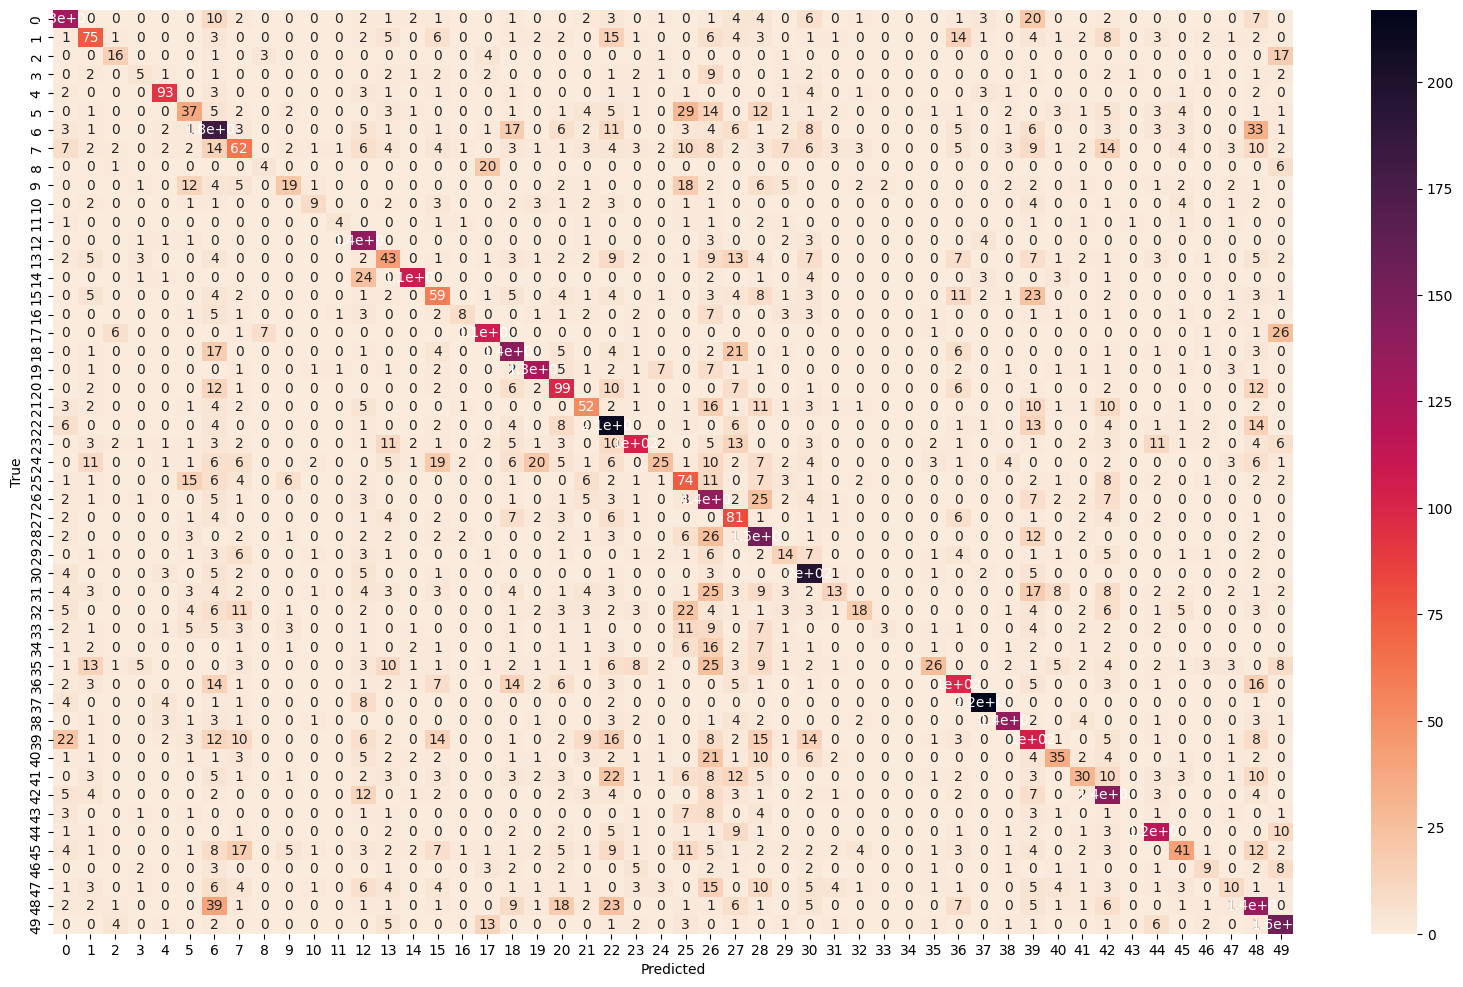

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred)

# Seaborn heatmap
fig, ax = plt.subplots(figsize=(20,12))  
sns.heatmap(confusion_mat, annot=True, cmap='rocket_r')

# set plot labels
plt.xlabel('Predicted')
plt.ylabel('True')

# show plot
plt.show()